In [10]:
!pip install shap
!pip install -U ultralytics
!pip install torchvision
!git clone https://github.com/ultralytics/yolov5
!git clone https://github.com/biplav-s/image-mask-estimate

   ---------------------------------------- 0.0/883.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.0 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/883.0 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/883.0 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 883.0/883.0 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.6
    Uninstalling ultralytics-8.3.6:
      Successfully uninstalled ultralytics-8.3.6


fatal: destination path 'yolov5' already exists and is not an empty directory.
fatal: destination path 'image-mask-estimate' already exists and is not an empty directory.


In [11]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


'export' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
!ls ../Yolov8_XAI_experiment_drive/MyDrive/Yolov8_XAI_experiment_drive
!cd ../Yolov8_XAI_experiment_drive/MyDrive/Yolov8_XAI_experiment_drive
%cd ../Yolov8_XAI_experiment_drive/MyDrive/Yolov8_XAI_experiment_drive

'ls' is not recognized as an internal or external command,
operable program or batch file.


[WinError 3] A rendszer nem találja a megadott elérési utat: '../Yolov8_XAI_experiment_drive/MyDrive/Yolov8_XAI_experiment_drive'
D:\Repos\yolov8_XAI\Yolov8_XAI_experiment


A rendszer nem tal lja a megadott el‚r‚si utat.
D:\Repos\yolov8_XAI\Yolov8_XAI_experiment\venv\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [13]:
!pip install shap

In [1]:
import random
from glob import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import ultralytics
import torchvision
import cv2
from ultralytics.utils.torch_utils import select_device
from ultralytics.utils.metrics import box_iou
from ultralytics.utils.ops import non_max_suppression
device = torch.device('cuda:0')

D:\Repos\yolov8_XAI\Yolov8_XAI_experiment\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [4]:
model = torch.load("models/best-box.pt", map_location=device)['model'].float()#.autoshape()

In [5]:
def image_processing(path,img_size,show_image_processing=0):
  img_org = cv2.imread(path, cv2.IMREAD_COLOR)
  img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
  old_img_size = img_org.shape[:2] # old size is in (height, width) format

  ratio = float(img_size)/max(old_img_size)
  new_size_y, new_size_x = tuple([int(x*ratio) for x in old_img_size])
  img = cv2.resize(img_org, (new_size_x, new_size_y))

  delta_w = img_size - new_size_x
  delta_h = img_size - new_size_y
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  #for making a square image as model expects
  img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

  img = img.astype("float32")/255
  img_gray = rgb2gray(img)

  if show_image_processing :
    plt.figure(figsize=(15, 15))
    plt.imshow(img_org)
    plt.show()

    fig = plt.figure(figsize=(20, 40))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
    plt.show()
  return img_org,img,img_gray

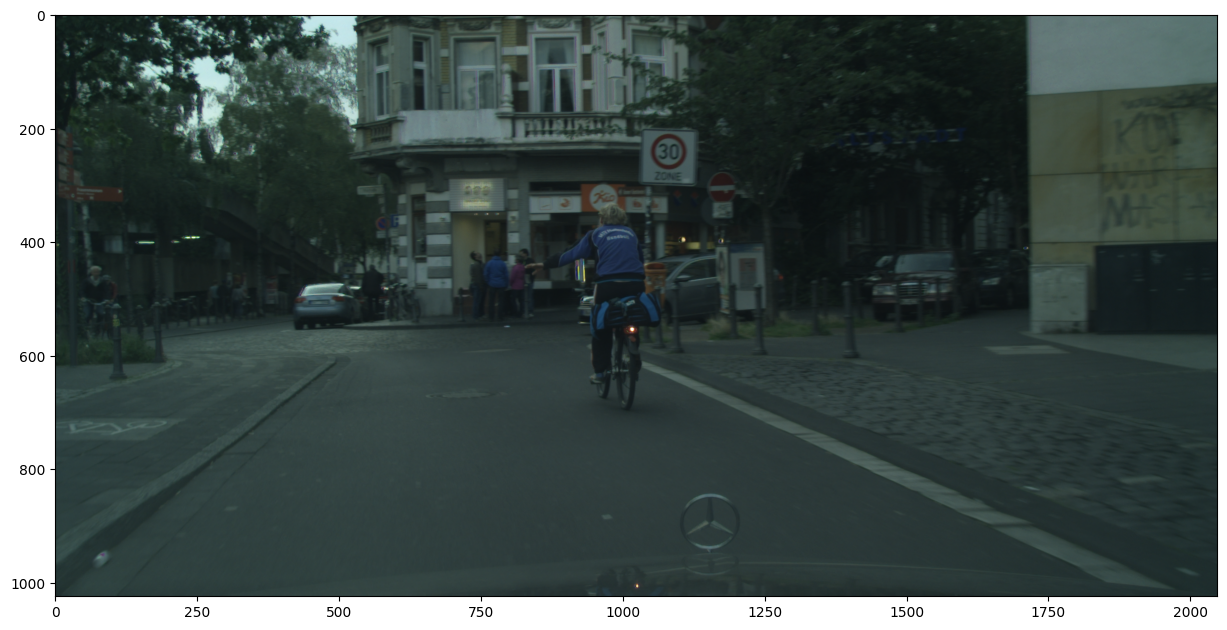

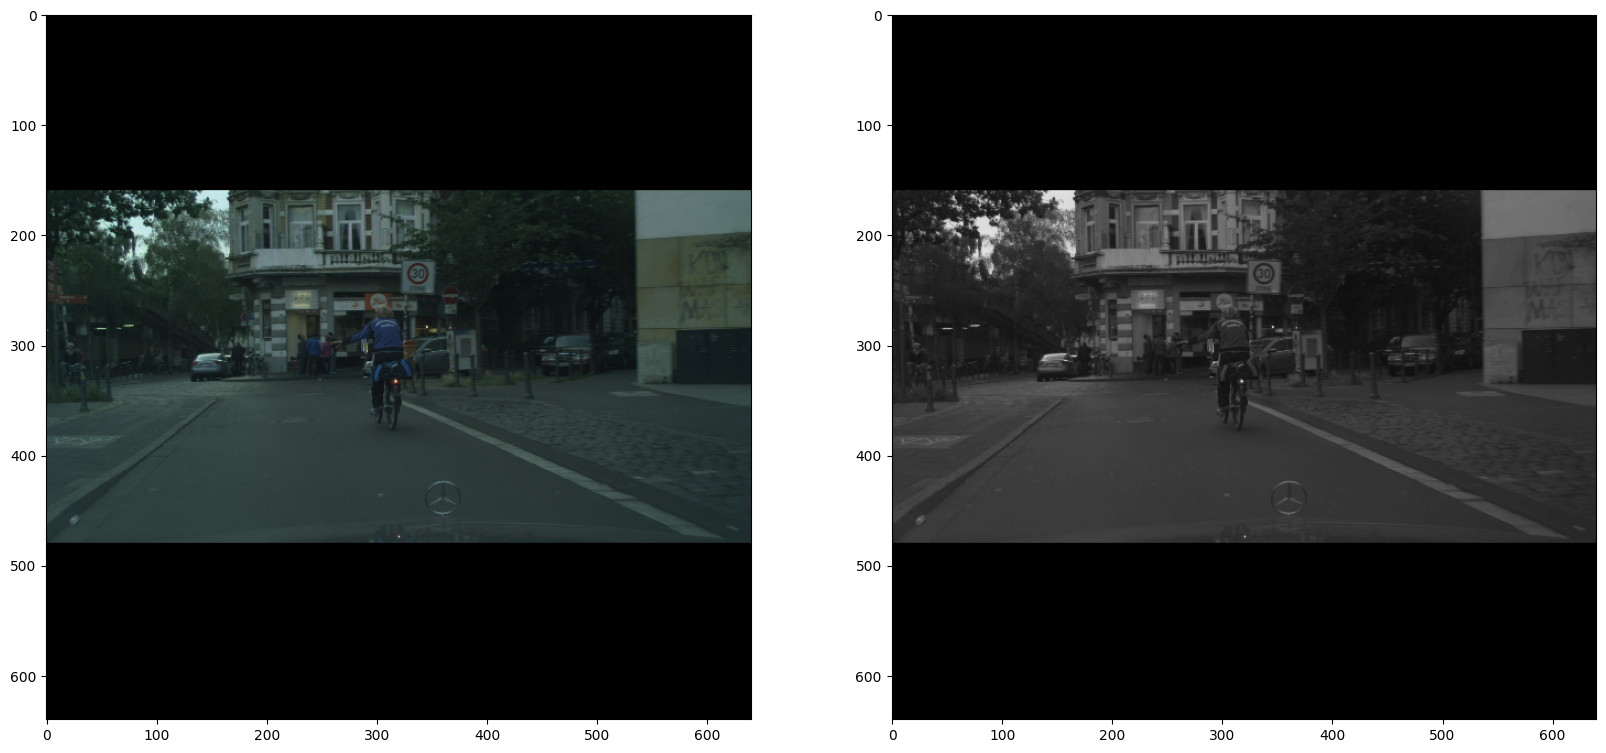

In [6]:
img_path='./data/gtFine/images/test/bonn/bonn_000036_000019_leftImg8bit.png'
img_org,img_pre,img_gray=image_processing(img_path,20*32,1)

In [7]:
def model_processing(img,confidence,iou,show_yolo_result=0):
  torch_image = torch.from_numpy(np.ascontiguousarray(img.transpose(2, 0, 1))).to(device).unsqueeze(0)
  with torch.no_grad():
    prediction = model(torch_image.float())
  output = non_max_suppression(prediction[0], conf_thres=confidence, iou_thres=iou)
  if show_yolo_result :
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)

    plt.imshow(img)
    print(model.names)
    print(img.shape)
    for i, detection in enumerate(output[0].cpu().numpy()):
      print(detection)
      try:  # Try to access the label using the predicted index
        label = f"{model.names[int(detection[5])]} {detection[4]:0.1%} ({i})"
      except KeyError:  # Handle the case where the index is not found
          label = f"Unknown Class {int(detection[5])} {detection[4]:0.1%} ({i})"  # Or handle it differently
      bbox = patches.Rectangle(detection[:2], detection[2]-detection[0], detection[3]-detection[1], linewidth=3, edgecolor='g', facecolor='none')
      plt.text(detection[0], detection[1], label, color="red")
      ax.add_patch(bbox)
    plt.show()

  return output,prediction

{0: 'small_vehicle', 1: 'person', 2: 'large_vehicle', 3: 'two-wheeler', 4: 'On-rails'}
(640, 640, 3)
[     448.31      287.51      507.34      329.69     0.87469           0]
[     131.23      307.06      169.97      333.43     0.87153           0]
[     496.68      287.56      538.46      322.55     0.82871           0]
[     269.83      263.74      330.52      363.59     0.82191           1]
[     13.812      297.65      34.764      336.91     0.74135           1]
[     235.29      288.13      251.29      329.53     0.73368           1]
[     167.79      296.34         182      328.52     0.71648           1]
[     178.17      304.93      201.27       329.5     0.68596           3]
[     226.35      289.87       238.6      329.18     0.65988           1]
[     291.98      306.42      332.65      377.97     0.64535           3]
[     322.21      287.48      402.32      331.27     0.61875           0]
[      95.77       302.7       106.5      329.05     0.58402           1]
[     248.8

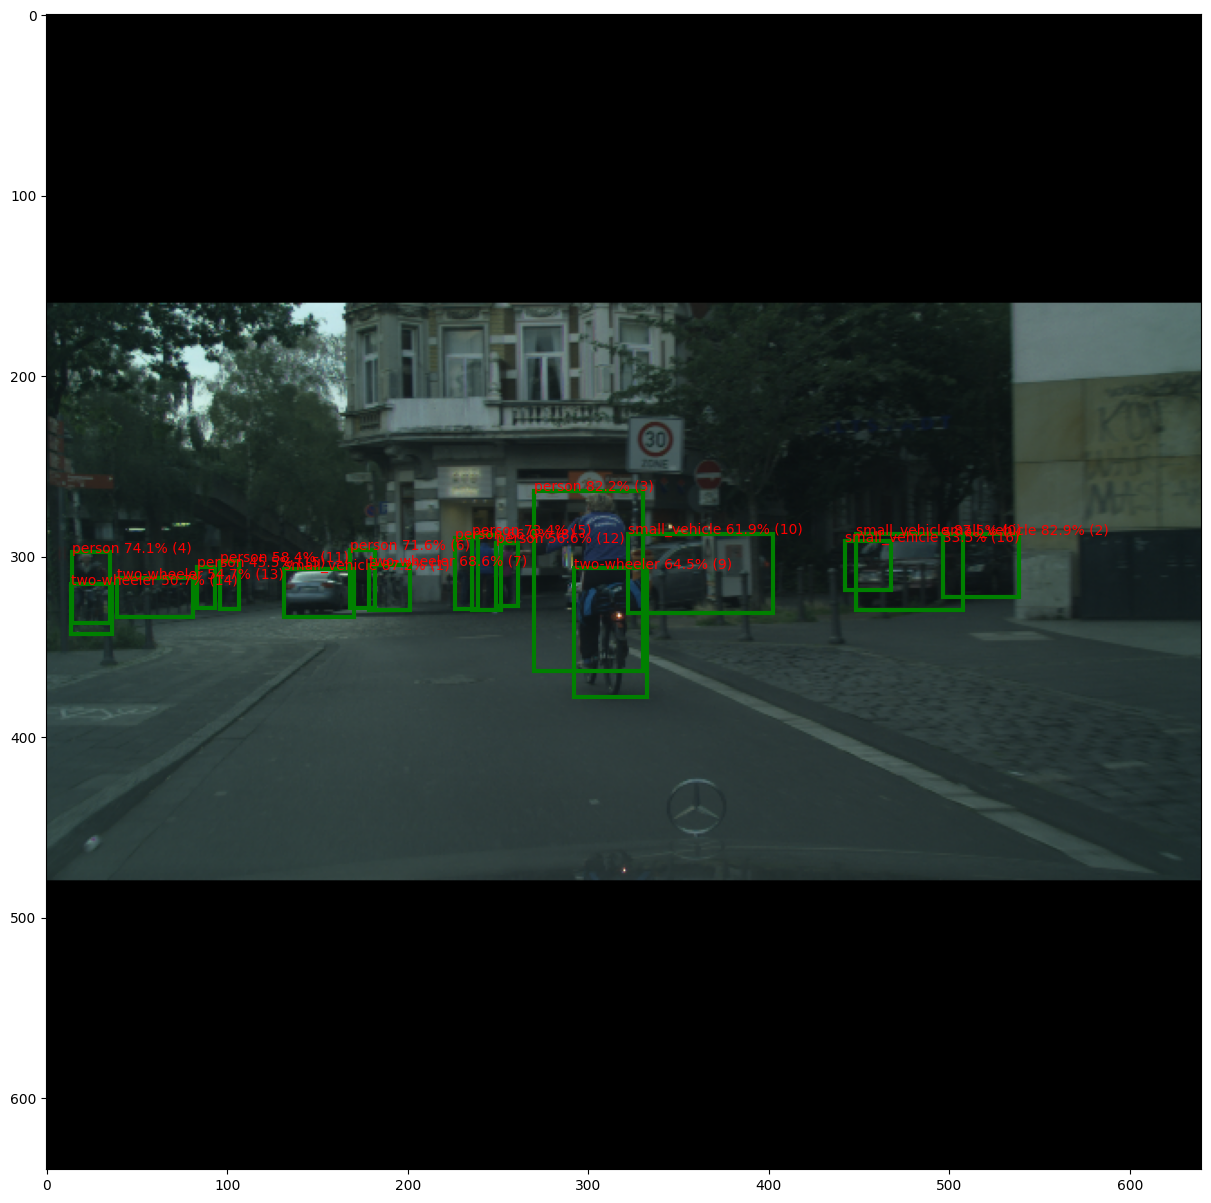

In [8]:
output,prediction=model_processing(img_pre,0.3,0.3,1)

In [9]:
print(output[0].shape)

torch.Size([17, 6])


In [10]:
class CastNumpy(torch.nn.Module):
  def __init__(self):
    super(CastNumpy, self).__init__()

  def forward(self, image):
    #In the forward function we accept the inputs and cast them to a pytorch tensor
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image).to(device)
    if image.ndimension() == 3:
      image = image.unsqueeze(0)
    return image

numpy2torch_converter = CastNumpy()

In [11]:
numpy2torch_converter.forward(img_pre.transpose(2, 0, 1))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [12]:
class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)

    def forward(self, x):
        #In the forward function we accept the predictions and return the score for a selected target of the box
        score_best_box = torch.zeros([x[0].shape[0]], device=device)

        for idx, img in enumerate(x[0]):
          img = img.unsqueeze(0)

          output = non_max_suppression(img, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)
          if output and output[0] is not None:
            correct_class_predictions = output[0][...,5] == self.target[5]
            correctly_labeled_boxes = output[0][correct_class_predictions]

            if correctly_labeled_boxes.shape[0]:
              iou_with_target, _idx = box_iou(correctly_labeled_boxes[:,:4], self.target.unsqueeze(0)[:,:4]).max(1)
              index_best_box_in_correct_class = torch.argmax(iou_with_target)
              index_best_box_in_output = torch.where(output[0][...,5] == self.target[5])[0][index_best_box_in_correct_class]

              score_best_box[idx] = output[0][index_best_box_in_output][4]*iou_with_target[index_best_box_in_correct_class]

        return score_best_box.cpu().numpy()

In [13]:
# look at the image output above and set the index of the object you want to analyze here
target_index = 3
target = output[0].cpu().numpy()[target_index,:]
scoring = OD2Score(target, conf_thresh=0.3, iou_thresh=0.3)
print(scoring.forward(prediction), "# score for target prediction")

[   0.041451] # score for target prediction


In [14]:
class SuperPixler(torch.nn.Module):
  def __init__(self, image, super_pixel_width):
    super(SuperPixler, self).__init__()

    self.image = image.transpose(2, 0, 1) # model expects images in BRG, not RGB, so transpose color channels
    self.mean_color = self.image.mean()
    self.image = np.expand_dims(self.image, axis=0)
    self.image_width = image.shape[1]
    self.super_pixel_width = super_pixel_width


  def forward(self, x):
    #In the forward step we accept the super pixel masks and transform them to a batch of images
    pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)

    for i, super_pixel in enumerate(x.T):
      images_to_pixelate = [bool(p) for p in super_pixel]
      x = (i*self.super_pixel_width//self.image_width)*self.super_pixel_width
      y = i*self.super_pixel_width%self.image_width
      pixeled_image[images_to_pixelate,:,x:x+self.super_pixel_width, y:y+self.super_pixel_width] = self.mean_color

    return pixeled_image

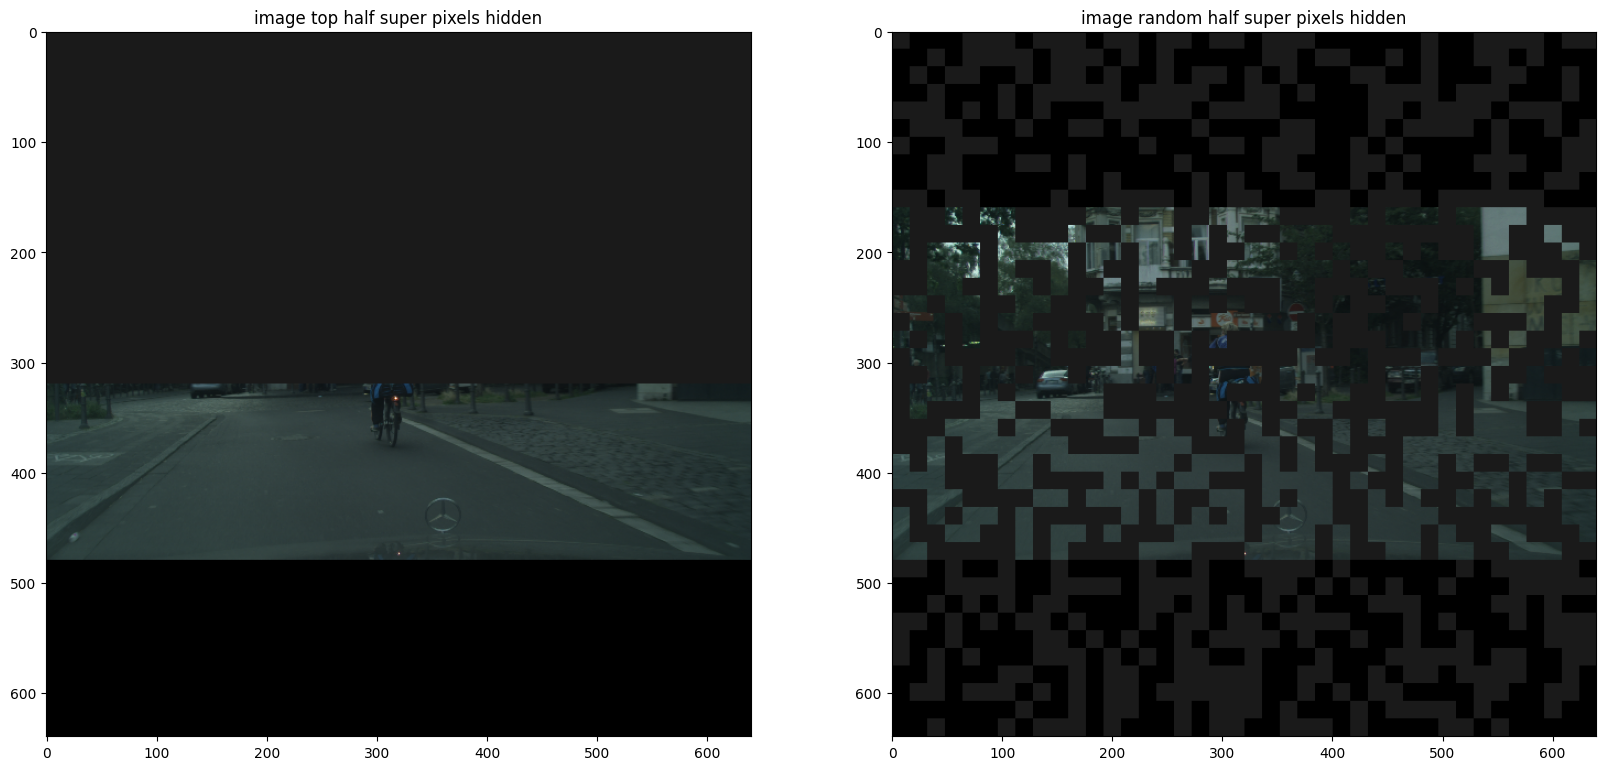

In [15]:
super_pixel_width = 16
assert (320/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"
n_super_pixel = int((img_pre.shape[1]/super_pixel_width)**2)

super_pixler = SuperPixler(img_pre, super_pixel_width = super_pixel_width)
img_s = super_pixler.forward(np.array([[1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)],
                                       [random.randint(0,1) for _ in range(n_super_pixel)]]))
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("image top half super pixels hidden")
ax1.imshow(img_s[0,:,:,:].transpose(1,2,0))
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("image random half super pixels hidden")
ax2.imshow(img_s[1,:,:,:].transpose(1,2,0))
plt.show()

In [16]:
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

In [30]:
score = super_pixel_model(torch.from_numpy(np.array([[1 for _ in range(n_super_pixel)]])).to(device,dtype=torch.float32))
print(score, "# score for whole image hidden")
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)], # empty image
                                    [0 for _ in range(n_super_pixel)], # full image
                                    [1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], # top half blacked out
                                    [random.randint(0,1) for _ in range(n_super_pixel)]])) # randomly half the patches blacked out
print(score, "# scores for all, none, top half, random half of the image hidden")

[          0] # score for whole image hidden
[          0     0.82191           0           0] # scores for all, none, top half, random half of the image hidden


In [17]:
from IPython.display import clear_output

In [23]:
from pathlib import Path


def shap_result(img,img_gray,target,target_index,super_pixel_width,img_size,scoring):
  # use Kernel SHAP to explain the detection
  assert (img_size/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"
  n_super_pixel = int((img.shape[1]/super_pixel_width)**2)
  super_pixler = SuperPixler(img, super_pixel_width = super_pixel_width)

  super_pixel_model = torch.nn.Sequential(
                                          super_pixler,
                                          numpy2torch_converter,
                                          model,
                                          scoring
                                          )

  background_super_pixel = np.array([[1 for _ in range(n_super_pixel)]])
  image_super_pixel = np.array([[0 for _ in range(n_super_pixel)]])
  kernel_explainer = shap.KernelExplainer(super_pixel_model, background_super_pixel)

  # Very large values for nsamples cause OOM errors depending on image and super pixel parameter. We combine batches of SHAP values to distribute the load.
  collected_shap_values = np.zeros_like(background_super_pixel)

  # take shap value with highest abs. value for each pixel from each batch
  b=10
  for i in range(b):
    print(f"{target_index}> {i/b:0.2%}")

    shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=1000)
    stacked_values = np.vstack([shap_values, collected_shap_values])
    index_max_values = np.argmax(np.abs(stacked_values), axis=0)
    collected_shap_values = stacked_values[index_max_values, range(shap_values.shape[1])]
  clear_output()
  print((collected_shap_values!=0).sum(), "non-zero shap values found")
  # plot the found SHAP values. Expected value does not match due to merging of batches
  shap.initjs()
  out_path= Path('D:/Repos/yolov8_XAI/Yolov8_XAI_experiment/output/explain/SHAP/feature'+f"{img_path}")
  out_path.mkdir(parents=True, exist_ok=True)
  shap.force_plot(kernel_explainer.expected_value, collected_shap_values, show=False,matplotlib=True).savefig(out_path /(str(target_index)+'.png'))
  # match super pixels back to image pixels
  shap_to_pixel = collected_shap_values.reshape(img_size//super_pixel_width, img_size//super_pixel_width)# reshape to square
  shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=0)# extend superpixles to the right
  shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=1)# and down
  shap_to_pixel = shap_to_pixel/(np.max(np.abs(collected_shap_values))*2) + 0.5 # center values between 0 and 1 for the colour map

  return shap_to_pixel

In [33]:
shap_to_pixel = shap_result(img_pre,img_gray,target,3,16,320,scoring)

3> 0.00%


  0%|          | 0/1 [00:00<?, ?it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x000001E1F5C70B80>
Traceback (most recent call last):
  File "D:\Repos\yolov8_XAI\Yolov8_XAI_experiment\venv\Lib\site-packages\tqdm\std.py", line 1196, in __iter__
    self.close()
  File "D:\Repos\yolov8_XAI\Yolov8_XAI_experiment\venv\Lib\site-packages\tqdm\std.py", line 1265, in close
    def close(self):

KeyboardInterrupt: 
  0%|          | 0/1 [00:12<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.31 GiB. GPU 0 has a total capacity of 5.00 GiB of which 0 bytes is free. Of the allocated memory 4.68 GiB is allocated by PyTorch, and 17.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:

import time

In [21]:
def over_all(path,img_size,confidence,iou,super_pixel_width,show_image_processing=0,show_yolo_result=0):
  start = time.time()
  img_org,img_pre,img_gray=image_processing(path,img_size,show_image_processing)
  output,prediction = model_processing(img_pre,confidence,iou,show_yolo_result)
  fig, ax = plt.subplots(1, output[0].shape[0], figsize=(output[0].shape[0]*10,output[0].shape[0]*10),squeeze=False)

  for target_index in range(output[0].shape[0]):
    target = output[0].cpu().numpy()[target_index,:]
    scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou)
    numpy2torch_converter = CastNumpy()
    shap_to_pixels = shap_result(img_pre,img_gray,target,target_index,super_pixel_width,img_size,scoring)
    # plot image and shap values for super pixels on top
    ax[0][target_index].set_title("Super pixel contribution to target detection")
    ax[0][target_index].imshow(img_gray,cmap="gray",alpha=0.8)
    ax[0][target_index].imshow(shap_to_pixels, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.2)

    # Add bounding box of target
    label = f"{model.names[int(target[5])]}"
    ax[0][target_index].text(target[0], target[1], label, color="green")
    bbox = patches.Rectangle(target[:2], target[2]-target[0], target[3]-target[1], linewidth=1, edgecolor='g', facecolor='none')
    ax[0][target_index].add_patch(bbox)
    end = time.time()
    print(f'Time taken: {end-start}')
  plt.show()

400 non-zero shap values found


Time taken: 17437.6191675663


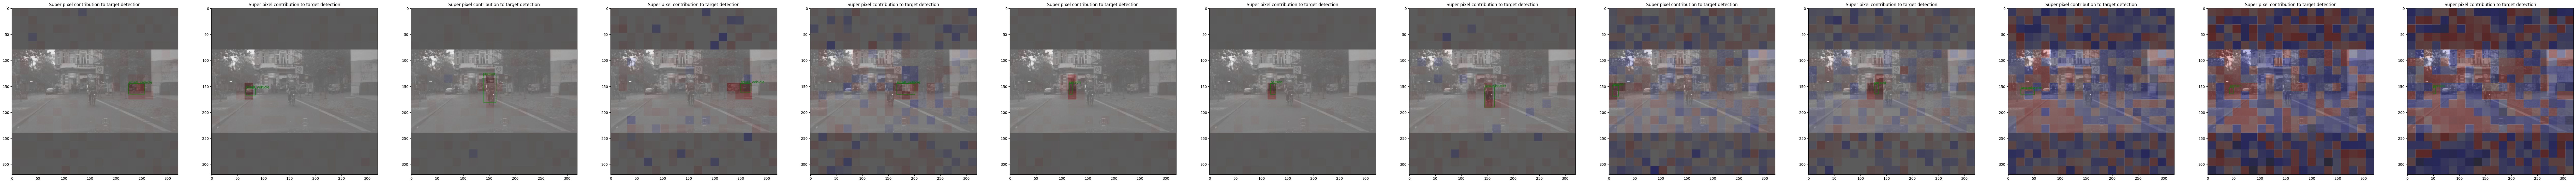

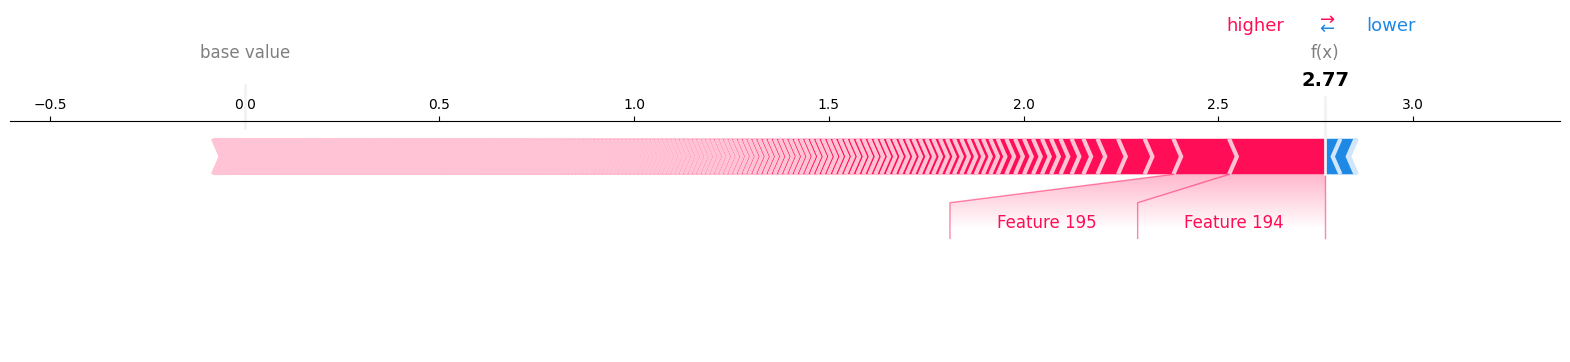

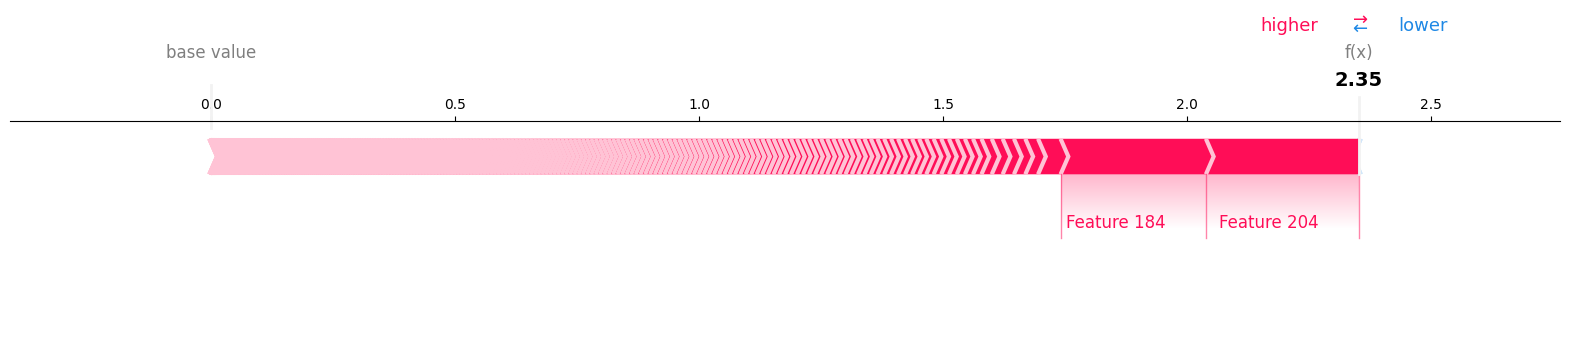

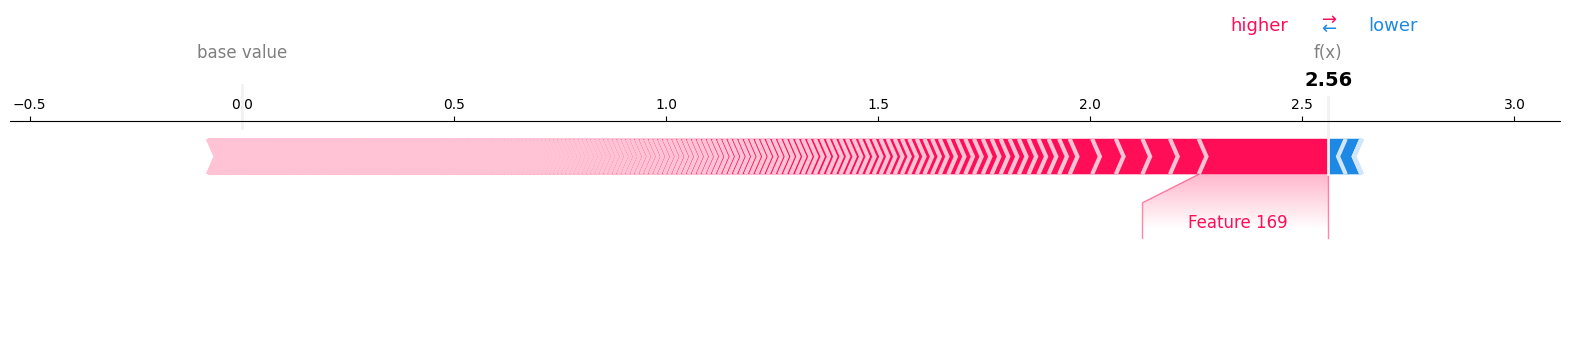

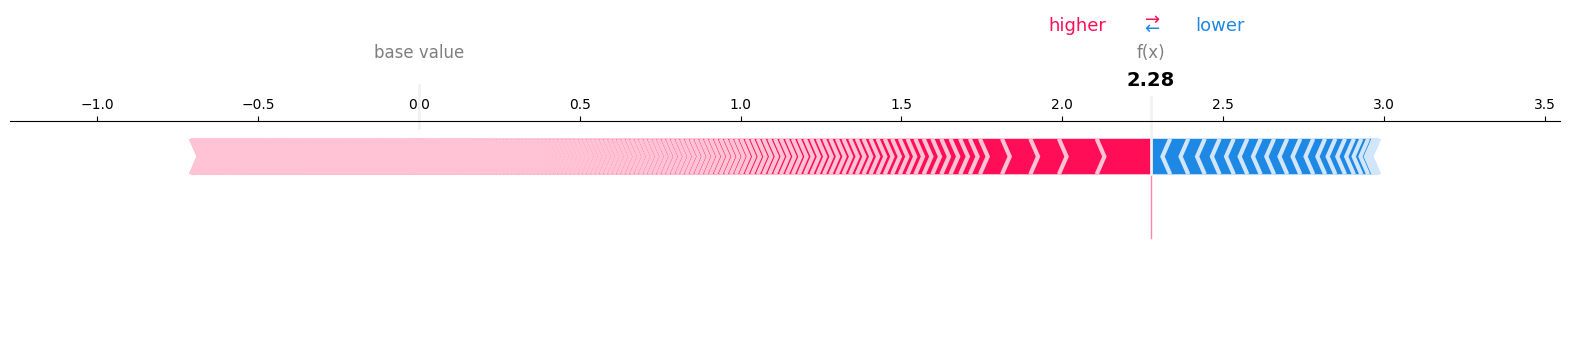

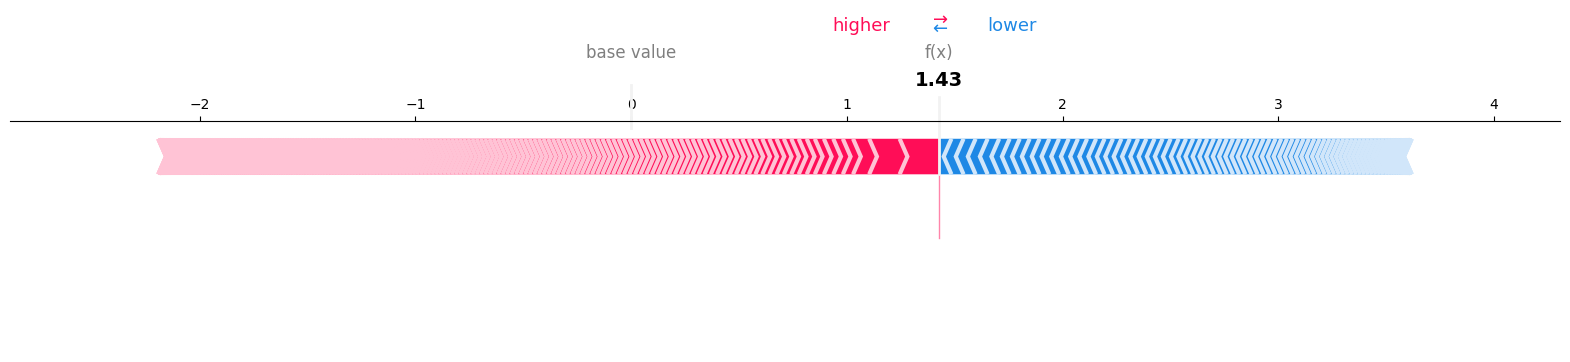

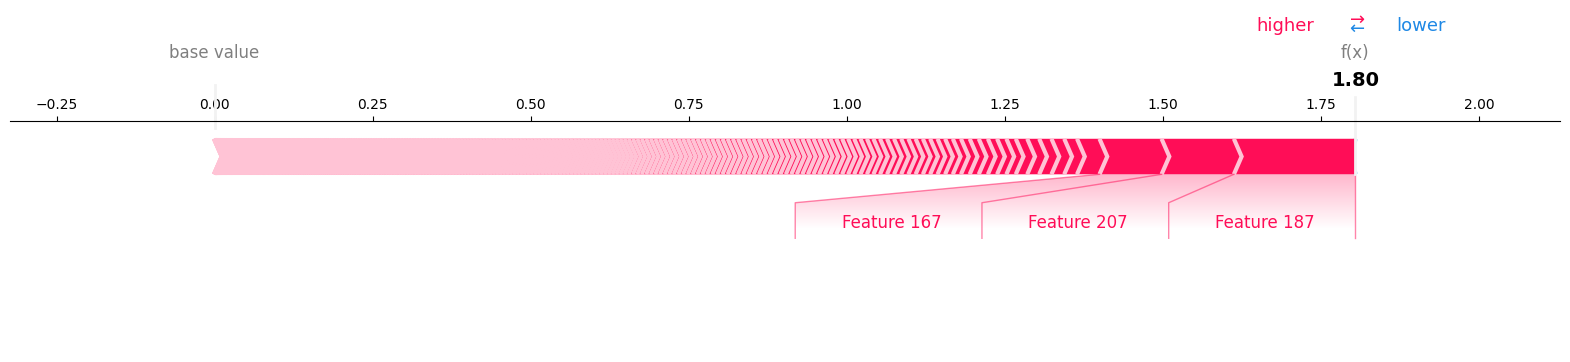

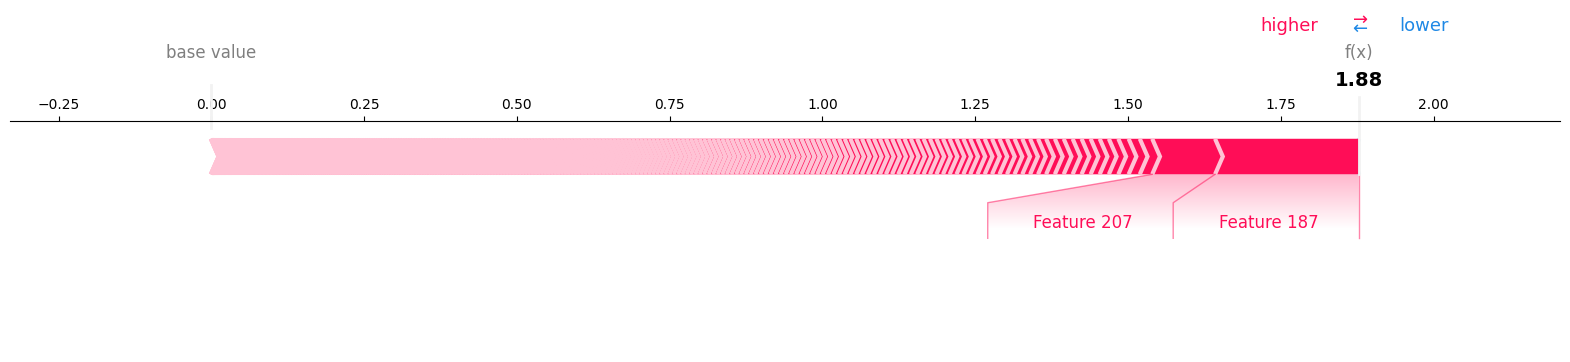

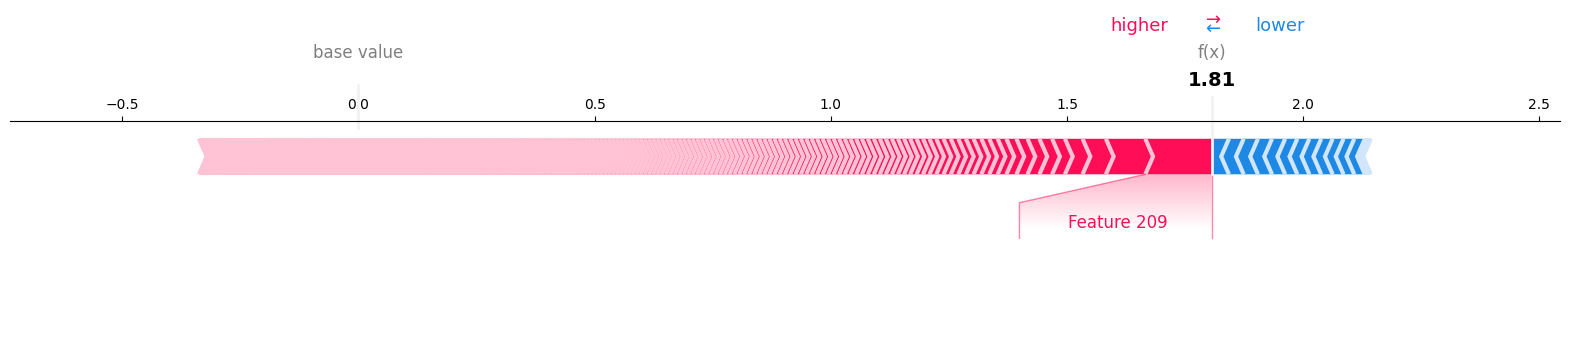

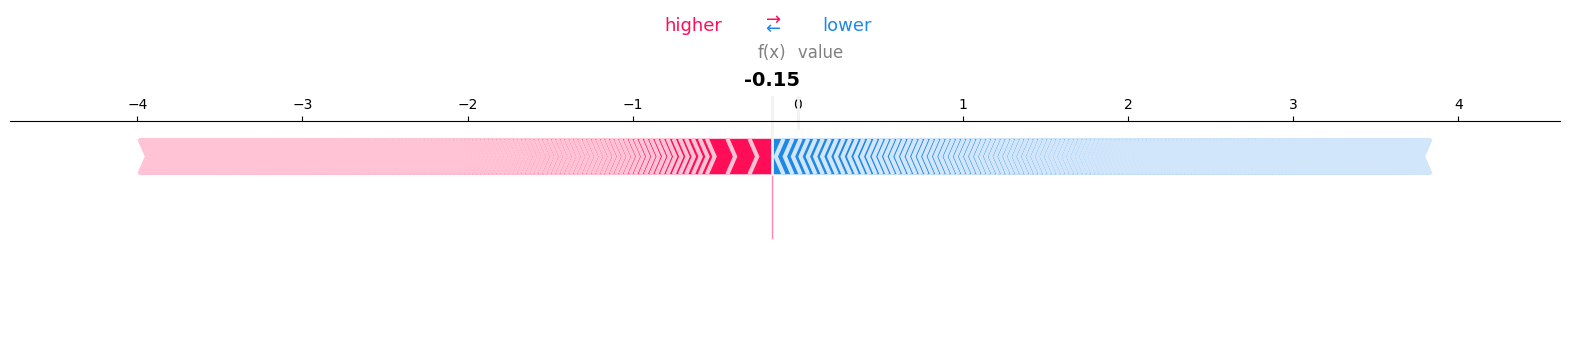

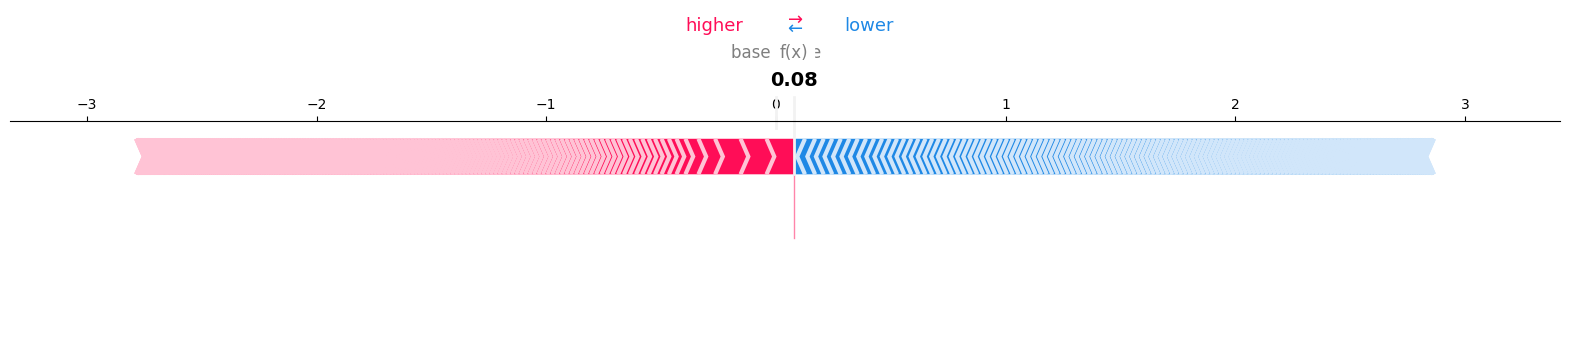

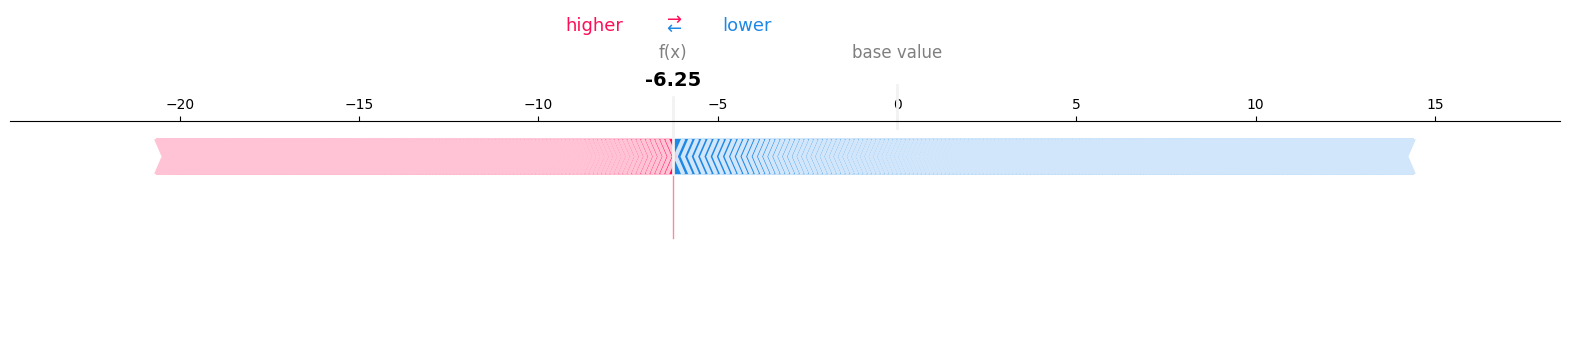

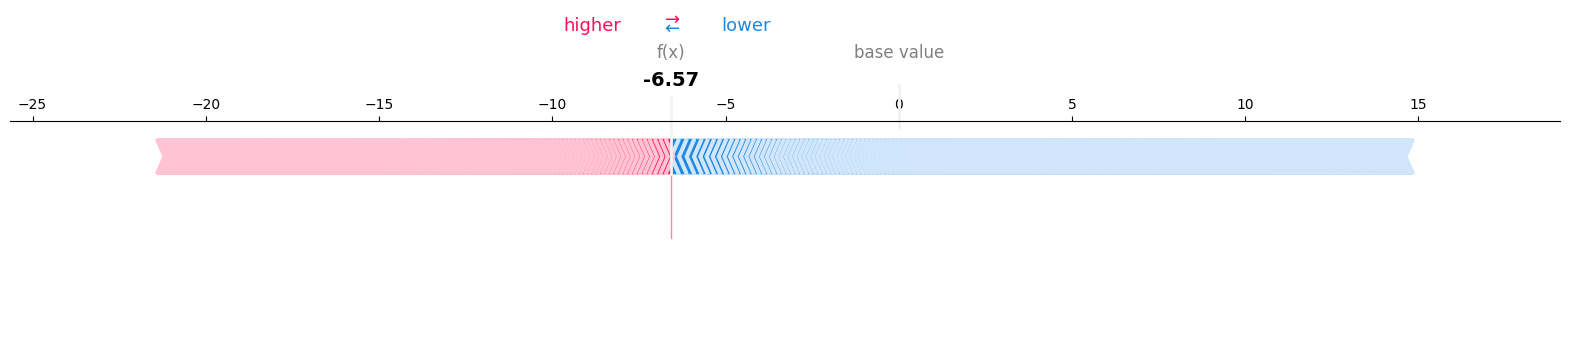

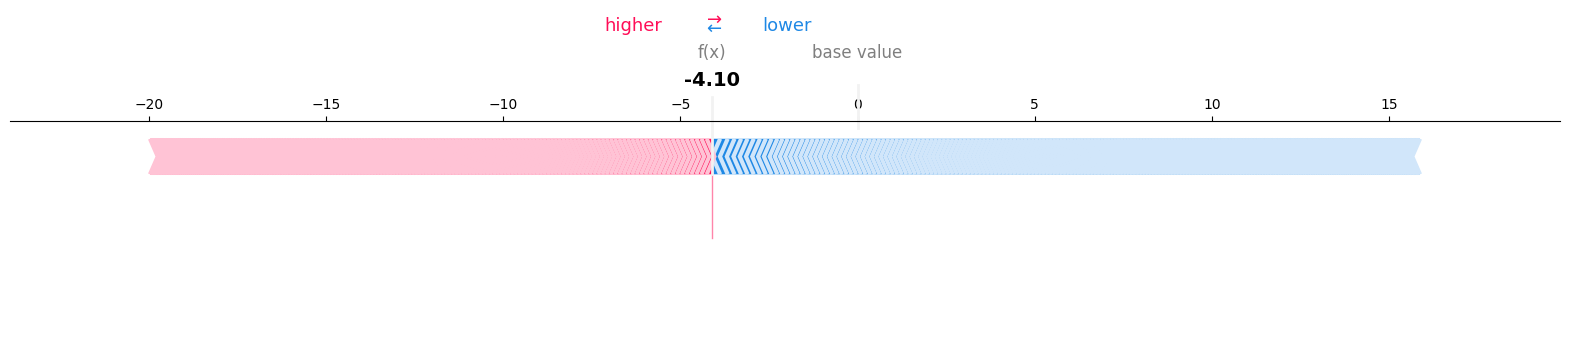

In [24]:
over_all(img_path,320,0.3,0.3,16,0,1)